In [1]:
# set up the environment
%pylab
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
sns.set()
import pandas as pd
import scipy as sp
import scipy.stats
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/kallus/Applications/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
d = 100
beta = np.hstack((np.ones(d/2),np.zeros(d/2)))
def generate_data(n):
    X = np.random.randn(n,d)
    Y = X.dot(beta) + np.random.randn()
    return Y,X

In [3]:
## MLE estimated SE matches true SE
np.random.seed(0)
y,x = generate_data(1)
print sm.OLS(*generate_data(200)).fit().get_prediction(x).se_mean[0]
preds = [sm.OLS(*generate_data(200)).fit().predict(x) for i in range(200)]
print np.std(preds)

1.19594889216
1.0088192231


In [6]:
## estimated SE from OLS for lasso-selected featureset
np.random.seed(0)
n = 50
Y,X = generate_data(n)
lasso = linear_model.LassoCV().fit(X,Y)
lassofeatures = np.abs(lasso.coef_)>1e-10
print lassofeatures
print sm.OLS(Y,X[:,lassofeatures]).fit().get_prediction(x[:,lassofeatures]).se_mean[0]


[ True False False False False  True  True False False  True False False
  True False  True  True  True  True False False False False False False
  True  True False False  True False False  True False  True False False
 False  True  True False False False False  True  True  True False  True
 False False False False False False False False False False  True  True
 False False False False False False False  True False False  True  True
 False False False False False False False False False  True False False
 False False False  True False False False  True False False  True  True
 False False False False]
1.09262759432


In [7]:
## true SE is much higher
lamb = lasso.alpha_
preds = np.zeros(200)
for i in range(200):
    Y,X = generate_data(n)
    lasso = linear_model.Lasso(alpha=lamb).fit(X,Y)
    lassofeatures = np.abs(lasso.coef_)>1e-10
    preds[i] = sm.OLS(Y,X[:,lassofeatures]).fit().predict(x[:,lassofeatures])[0]
print np.std(preds)

5.9619919711


In [ ]:
### The bootstrap

In [9]:
def gen_data(n):
    return np.random.exponential(10,n)
#     mix=np.random.randint(0,2,n)
#     return mix*0.5*np.random.randn(n) + (1-mix)*(3+np.random.randn(n))


(array([  6.10600000e+03,   2.32600000e+03,   9.44000000e+02,
          3.63000000e+02,   1.59000000e+02,   6.20000000e+01,
          2.40000000e+01,   8.00000000e+00,   6.00000000e+00,
          2.00000000e+00]),
 array([  1.27977125e-04,   9.20496931e+00,   1.84098106e+01,
          2.76146520e+01,   3.68194933e+01,   4.60243346e+01,
          5.52291760e+01,   6.44340173e+01,   7.36388586e+01,
          8.28436999e+01,   9.20485413e+01]),
 <a list of 10 Patch objects>)

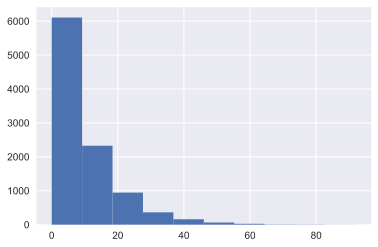

In [10]:
hist(gen_data(10000))

In [11]:
thetafn = lambda Z: np.median(Z)
# thetafn = lambda Z: np.percentile(Z,95)
# thetafn = lambda Z: sp.stats.kurtosis(Z)
theta = thetafn(gen_data(100000000))
print theta

6.93309141671


True SE = 0.584162962999


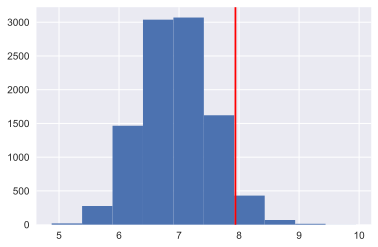

In [12]:
np.random.seed(1)
n = 300
Z = gen_data(n)
thetahat = thetafn(Z)
truedist = [thetafn(gen_data(n)) for i in range(10000)]
print 'True SE =',np.std(truedist)
hist(truedist)
axvline(thetahat,color='r')

Bootstrap SE = 0.596902830106


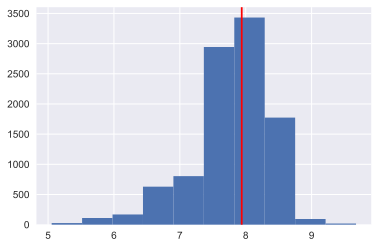

In [13]:
bootdist = [thetafn(np.random.choice(Z,n)) for i in range(10000)]
print 'Bootstrap SE =',np.std(bootdist)
hist(bootdist)
axvline(thetahat,color='r')

(array([   26.,   110.,   169.,   629.,   804.,  2944.,  3432.,  1774.,
           94.,    18.]),
 array([ 5.05452542,  5.51654038,  5.97855534,  6.4405703 ,  6.90258526,
         7.36460022,  7.82661518,  8.28863014,  8.7506451 ,  9.21266006,
         9.67467502]),
 <a list of 10 Patch objects>)

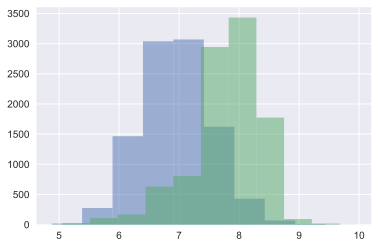

In [14]:
hist(truedist,alpha=0.5)
hist(bootdist,alpha=0.5)

(array([   26.,   110.,   169.,   629.,   804.,  2944.,  3432.,  1774.,
           94.,    18.]),
 array([ 4.0479875 ,  4.51000246,  4.97201742,  5.43403238,  5.89604734,
         6.35806231,  6.82007727,  7.28209223,  7.74410719,  8.20612215,
         8.66813711]),
 <a list of 10 Patch objects>)

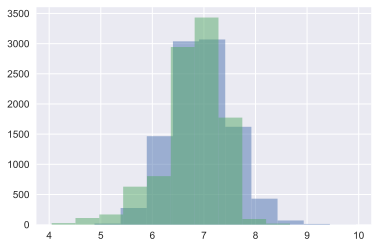

In [15]:
hist(truedist,alpha=0.5)
hist(bootdist-thetahat+theta,alpha=0.5)

In [16]:
# wald
hits = 0
runs = 500
n = 500
for i in range(runs):
    Z = gen_data(n)
    thetahat = thetafn(Z)
    bootSE = np.std([thetafn(np.random.choice(Z,n)) for i in range(1000)])
    hits += ((thetahat - 1.96*bootSE) <= theta <= (thetahat + 1.96*bootSE))
hits/float(runs)

0.93200000000000005

In [17]:
# pivotal
hits = 0
runs = 500
n = 500
for i in range(runs):
    Z = gen_data(n)
    thetahat = thetafn(Z)
    CI = np.percentile([2*thetahat-thetafn(np.random.choice(Z,n)) for i in range(1000)],[2.5,97.5])
    hits += (CI[0] <= theta <= CI[1])
hits/float(runs)


0.92600000000000005

In [18]:
# percentile
hits = 0
runs = 500
n = 500
for i in range(runs):
    Z = gen_data(n)
    thetahat = thetafn(Z)
    CI = np.percentile([thetafn(np.random.choice(Z,n)) for i in range(1000)],[2.5,97.5])
    hits += (CI[0] <= theta <= CI[1])
hits/float(runs)


0.96199999999999997

In [19]:
with open("ARM_data/child.iq/kidiq.dta") as f:
    kidiq = pd.read_stata(f)
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


(array([   1.,   15.,   30.,   47.,   56.,  110.,  112.,   51.,    9.,    3.]),
 array([  20. ,   32.4,   44.8,   57.2,   69.6,   82. ,   94.4,  106.8,
         119.2,  131.6,  144. ]),
 <a list of 10 Patch objects>)

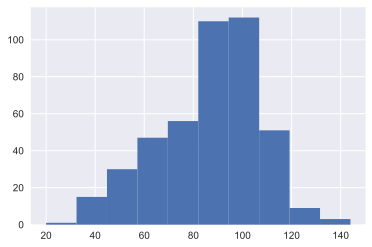

In [20]:
hist(kidiq.kid_score)

In [21]:
thetafn = lambda z: np.mean(z[z>=np.percentile(z,80)])

In [22]:
thetafn(kidiq.kid_score)

111.33333333333333

In [23]:
from arch.bootstrap import IIDBootstrap

In [24]:
# pivotal
IIDBootstrap(kidiq.kid_score).conf_int(
    thetafn,
    1000,
    method='basic')

array([[ 109.0530303],
       [ 113.580625 ]])

In [25]:
# wald
IIDBootstrap(kidiq.kid_score).conf_int(
    thetafn,
    1000,
    method='norm')

array([[ 109.1170682 ],
       [ 113.54959846]])

In [26]:
# percentile
IIDBootstrap(kidiq.kid_score).conf_int(
    thetafn,
    1000,
    method='percentile')

array([[ 109.0478403 ],
       [ 113.54306982]])

In [27]:
# bca
IIDBootstrap(kidiq.kid_score).conf_int(
    thetafn,
    1000,
    method='bca')

array([[ 109.11492178],
       [ 113.85373373]])

In [28]:
smf.ols('kid_score ~ mom_hs+mom_iq+C(mom_work)+mom_age', data=kidiq).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              kid_score   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     20.22
Date:                Mon, 26 Mar 2018   Prob (F-statistic):           7.55e-21
Time:                        16:32:39   Log-Likelihood:                -1870.0
No. Observations:                 434   AIC:                             3754.
Df Residuals:                     427   BIC:                             3783.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           20.2727      9.393      2.158      0.031       1.810      38.735
C(mom_work)[T.2]     2.9827      2.813      1.060      0.290      -2.546       8.511
C(mom_work)[T.3]     5.4882      3.252      1.687      0.092      -0.904      11.881
C(mom_work)[T.4]     1.4193      2.516      0.564      0.573      -3.526       6.365
mom_hs               5.4347      2.325      2.337      0.020       0.864      10.005
mom_iq               0.5529      0.061      9.008      0.000       0.432       0.674
mom_age              0.2163      0.334      0.649      0.517      -0.439       0.872
==============================================================================
Omnibus:                        6.368   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.525
Skew:                          -0.292   Prob(JB):                       0.0383
Kurtosis:                       2.862   Cond. No.                     1.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
def getmomiqcoeff(data):
    return smf.ols('kid_score ~ mom_hs+mom_iq+C(mom_work)+mom_age', data=data).fit().params['mom_iq']


In [30]:
IIDBootstrap(kidiq).conf_int(
    getmomiqcoeff,
    1000,
    method='basic')

array([[ 0.42823545],
       [ 0.66829605]])

In [31]:
IIDBootstrap(kidiq).conf_int(
    getmomiqcoeff,
    1000,
    method='bca')

array([[ 0.43338062],
       [ 0.65939969]])